<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и знакомство с данными</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Elastic-NET" data-toc-modified-id="Elastic-NET-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Elastic NET</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-спуск" data-toc-modified-id="Градиентный-спуск-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Градиентный спуск</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Описание данных**

Признаки

*	`datetime` — дата время.

Целевой признак

* `num_orders` — количество заказов

## Подготовка

### Импорт необходимых библиотек

In [1]:
#pip install statsmodels --upgrade

In [2]:
import time
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.simplefilter('ignore')

### Загрузка и знакомство с данными

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col='datetime')    
except FileNotFoundError:
    df = pd.read_csv('taxi.csv', parse_dates=True, index_col='datetime')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим что индекс, колонка с датой и временем, идет строго по возрастанию.

In [6]:
df.index.is_monotonic

True

Данные в хронологическом порядке, хорошо.


Проверим на наличие пропусков.

In [7]:
df.isnull().sum()

num_orders    0
dtype: int64

Пропусков нет.

Посмотрим за какой промежуток времени предоставлены данные.

In [8]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [9]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

Данные с 1 марта по 31 августа 2018 года

Проведем ресеплирование данных суммированием за промежутки по 1 часу

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены. Можно приступать к анализу.

## Анализ



In [12]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Среднее значение 84,4 выше медианы 78. Судя по максимальномузначению есть выбросы. Построим графики.

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

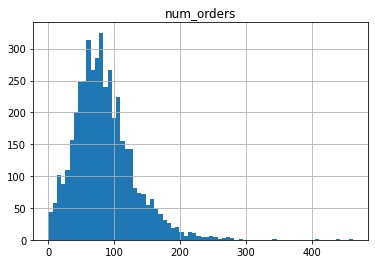

In [13]:
df.hist(bins='auto')

<AxesSubplot:>

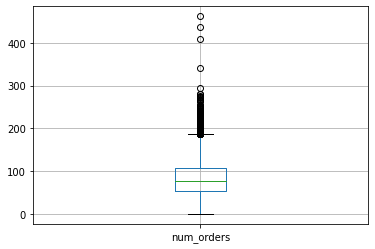

In [14]:
df.boxplot()

Распределение близко к нормальному. Немногь скошено вправо. 

По ящику с усами видны выбросы.

<AxesSubplot:xlabel='datetime'>

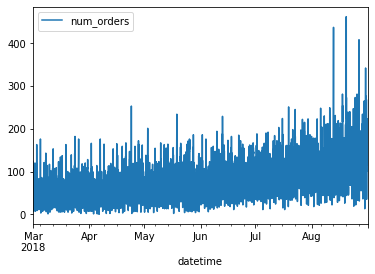

In [15]:
df.plot()

Выбросы в основном в августе месяце, есть еще единичные большие значения.

Выделим из данных тренд, сезонность и остатки и построим их графики

In [16]:
decompode_df = seasonal_decompose(df)

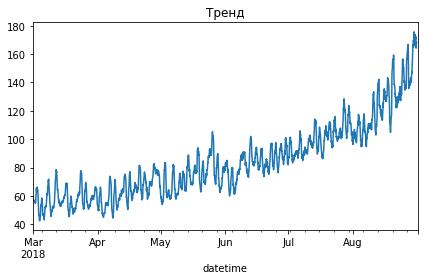

In [17]:
decompode_df.trend.plot()
plt.title('Тренд')
plt.tight_layout()

На графике тренда явно просматривается рост числа заказов такси в аэропорту к лету и в течениие всего лета. В августе достигает своего пика. Период отпусков и близость начала учебного года оказывает влияние.

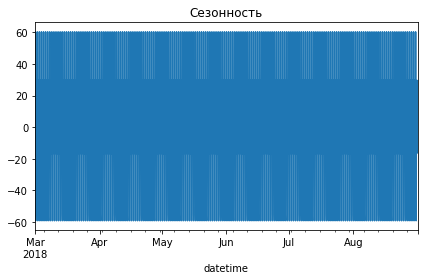

In [18]:
decompode_df.seasonal.plot()
plt.title('Сезонность')
plt.tight_layout()

Сезонность нужно видимо рассматриваь в более мелком масштабе: одного месяца, недели или даже суток.

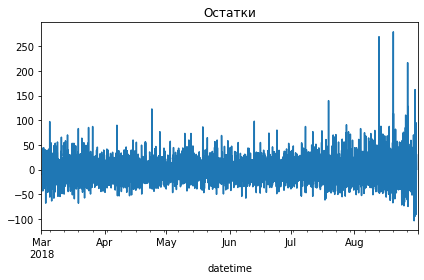

In [19]:
decompode_df.resid.plot()
plt.title('Остатки')
plt.tight_layout()

Остатков особенно много в августе, это выбивающиеся из общей картины пики.

Посмотрим на сезонность за одни месяц, напрмер июль.

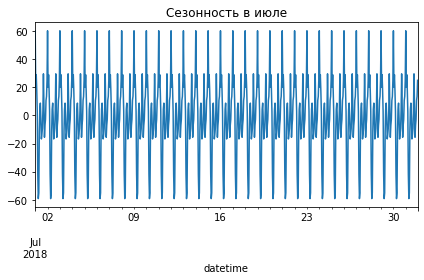

In [20]:
decompode_df.seasonal['2018-07-01':'2018-07-31'].plot()
plt.title('Сезонность в июле')
plt.tight_layout()

На этом графике уже видно, что сезонность стоит рассматривать в течение суток.

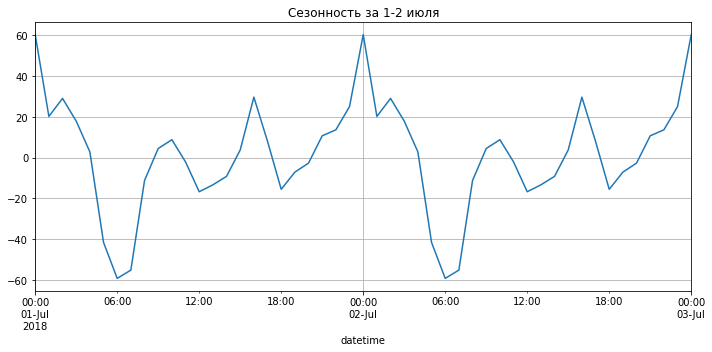

In [21]:
decompode_df.seasonal['2018-07-01 00:00:00':'2018-07-03 00:00:00'].plot(grid=True, figsize=(10,5))
plt.title('Сезонность за 1-2 июля')
plt.tight_layout()

Теперь видна зависимость от времени суток. После полуночи и до 6 утра спад. В утренние часы наблюдается рост и к обеду очередной спад, дальше вновь рост количества заказов примерно до 16:00 и вновь спад. С 18 до полуночи быстрый рост количества заказов и максимум достигается к полуночи.

Посмотрим на скользящие стреднее и стандартное отклонение.

<AxesSubplot:xlabel='datetime'>

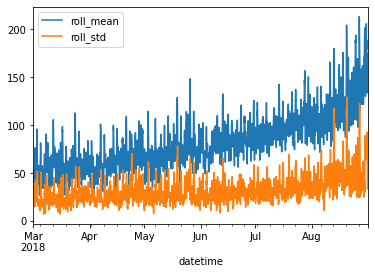

In [22]:
df['roll_mean'] = df['num_orders'].rolling(10).mean()
df['roll_std'] = df['num_orders'].rolling(10).std()
df[['roll_mean','roll_std']].plot()

Ряд не стационарный, среднее и стандартное оклонение меняются с течением времени.

Попробуем обучать модели и предсказывать такой ряд, если метрика RMSE  будет нас не устраивать, попробуем ряд сделать стационарным используя смещение.

In [24]:
df = df.drop(['roll_mean','roll_std'], axis=1)

## Обучение

Для обучения необходимо подготовить данные, а именно добавить в наш набор признаки:
1. День недели - думаю от дня недели есть влияние, в пятницу вечером скорее всего вызовов больше чем вечером в другой будний день;
2. Время (час) - от времени зависимость есть, мы видели на графике сезонности;
3. Фактор влияния предыдущих данных на текущее, lag;
4. Сглаживание, rolling.

Для добавления этих признаков будем использовать функцию

In [25]:
def add_features(data, n_lag, n_rol, col_target):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for i in range(1, n_lag+1, 1):
        data['lag_{}'.format(i)] = data[col_target].shift(i)
    data['rol_mean'] = data[col_target].shift().rolling(n_rol).mean()
    data = data.dropna()
    features = data.drop(col_target, axis=1)
    target = data[col_target]
    features_train, features_tets, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
    return features_train, features_tets, target_train, target_test, features, target

Для обучения моделе и предсказания будем использовать функции

In [26]:
def learn_model(model,x_train,y_train,GS_key=0, param=0):
    if GS_key == 0:
        start = time.time()
        model.fit(x_train,y_train)
        end = time.time()
        return model, end - start
    elif GS_key == 1:
        start = time.time()
        split_index = TimeSeriesSplit().split(x_train)
        grid_search_model = GridSearchCV(model, param, cv=split_index, scoring='neg_root_mean_squared_error', refit=True)
        grid_search_model.fit(x, y)
        end = time.time()
        return grid_search_model, end - start

def predict_model(model,x_test,y_test):
    start = time.time()
    pred = model.predict(x_test)
    end = time.time()
    rmse = mean_squared_error(y_test,pred,squared=False)
    return end - start, rmse, pred

In [27]:
compare_models = pd.DataFrame(columns=['Learning time','Predict time','RMSE'])

In [28]:
def add_model(learn_time,pred_time,rmse,model_name,df): #функция для добавления строчки 
    df.loc[model_name,'RMSE'] = rmse
    df.loc[model_name,'Learning time'] = learn_time
    df.loc[model_name,'Predict time'] = pred_time

In [29]:
x_train, x_test, y_train, y_test, x, y = add_features(df, 25, 10, 'num_orders')

In [30]:
print(x_train.shape)
print(x_test.shape)

(3951, 28)
(440, 28)


### Линейная регрессия

In [31]:
linear_regression_model, linear_regression_time_learn = learn_model(LinearRegression(),x_train,y_train)
linear_regression_time_pred, linear_regression_rmse, linear_regression_pred = predict_model(linear_regression_model,x_test,y_test)

In [32]:
linear_regression_rmse

45.23833491675803

In [33]:
add_model(linear_regression_time_learn,linear_regression_time_pred,linear_regression_rmse,'Linear regression',compare_models)

### Elastic NET

In [34]:
elastic_net_model, elastic_net_time_learn = learn_model(ElasticNet(random_state = 314),x_train,y_train)
elastic_net_time_pred, elastic_net_rmse, elastic_net_pred = predict_model(elastic_net_model,x_test,y_test)

In [35]:
elastic_net_rmse

45.226489239075946

In [36]:
add_model(elastic_net_time_learn,elastic_net_time_pred,elastic_net_rmse,'Elastic Net',compare_models)

Попробуем с помощью GridSearch подобрать гиперпараметры для модели ElasticNet что бы добиться лучшего значения метрики.

In [37]:
param_grid_en = [{'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5]}]
elastic_net_gs_model, elastic_net_gs_time_learn = learn_model(ElasticNet(random_state = 314),x_train,y_train,1,param_grid_en)
elastic_net_gs_time_pred, elastic_net_gs_rmse, elastic_net_gs_pred = predict_model(elastic_net_gs_model,x_test,y_test)

In [38]:
elastic_net_gs_rmse

44.029026684353454

In [39]:
add_model(elastic_net_gs_time_learn,elastic_net_gs_time_pred,elastic_net_gs_rmse,'Elastic Net GridSearch',compare_models)

### Дерево решений

In [40]:
decision_tree_model, decision_tree_time_learn = learn_model(DecisionTreeRegressor(random_state=314),x_train,y_train)
decision_tree_time_pred, decision_tree_rmse, decision_tree_pred = predict_model(decision_tree_model,x_test,y_test)

In [41]:
decision_tree_rmse

66.87777182021216

In [42]:
add_model(decision_tree_time_learn,decision_tree_time_pred,decision_tree_rmse,'Decision tree',compare_models)

Попробуем с помощью GridSearch подобрать гиперпараметры для модели ElasticNet что бы добиться лучшего значения метрики. 

In [43]:
param_grid_dt = [{'max_depth': range (3,8,1), 'max_features': range(1,9,1)}]
decision_tree_model_gs, decision_tree_time_learn_gs = learn_model(DecisionTreeRegressor(random_state=314),x_train,y_train,1,param_grid_dt)
decision_treet_time_pred_gs, decision_tree_rmse_gs, decision_tree_gs_pred = predict_model(decision_tree_model_gs,x_test,y_test)

In [44]:
decision_tree_rmse_gs

43.837339492767406

In [45]:
add_model(decision_tree_time_learn_gs,decision_treet_time_pred_gs,decision_tree_rmse_gs,'Decision tree GridSearch',compare_models)

In [46]:
decision_tree_rmse_gs

43.837339492767406

### Случайный лес

In [47]:
random_forest_model, random_forest_time_learn = learn_model(RandomForestRegressor(random_state=314),x_train,y_train)
random_forest_time_pred, random_forest_rmse, random_forest_pred = predict_model(random_forest_model,x_test,y_test)

In [48]:
random_forest_rmse

43.20767743226786

In [49]:
add_model(random_forest_time_learn,random_forest_time_pred,random_forest_rmse,'Random forest',compare_models)

Попробуем с помощью GridSearch подобрать гиперпараметры для модели случайного леса что бы добиться лучшего значения метрики

In [50]:
param_grid_rf = [{'max_depth': range (5,8,1), 'n_estimators': range(10,50,10)}]
random_forest_model_gs, random_forest_time_learn_gs = learn_model(RandomForestRegressor(random_state=314),x_train,y_train,1,param_grid_rf)
random_forest_time_pred_gs, random_forest_rmse_gs, random_forest_pred_gs = predict_model(random_forest_model_gs,x_test,y_test)

In [51]:
random_forest_rmse_gs

28.598258479228306

In [52]:
add_model(random_forest_time_learn_gs,random_forest_time_pred_gs,random_forest_rmse_gs,'Random forest GridSearch',compare_models)

### Градиентный спуск

In [53]:
gradient_boosting_model, gradient_boosting_time_learn = learn_model(GradientBoostingRegressor(random_state=314),x_train,y_train)
gradient_boosting_time_pred, gradient_boosting_rmse, gradient_boosting_pred  = predict_model(gradient_boosting_model,x_test,y_test)

In [54]:
gradient_boosting_rmse

41.802298797161974

In [55]:
add_model(gradient_boosting_time_learn,gradient_boosting_time_pred,gradient_boosting_rmse,'Gradient boosting',compare_models)

## Тестирование

Сравним полученные значения метрик для разных моделей и время затрачиваемое для обучения и предсказания. Все модели обучались на одинаковых данных.

In [56]:
compare_models

,Learning time,Predict time,RMSE
Linear regression,0.020316,0.003165,45.238335
Elastic Net,0.030489,0.002373,45.226489
Elastic Net GridSearch,5.525434,0.001631,44.029027
Decision tree,0.133058,0.002474,66.877772
Decision tree GridSearch,1.695036,0.001567,43.837339
Random forest,8.452193,0.021068,43.207677
Random forest GridSearch,22.473915,0.007173,28.598258
Gradient boosting,1.787015,0.004374,41.802299


Наилучшее значение метрики показала модель случайного леса деревьев после подбора гиперпараметров, но время затрачиваемое на обучение существенно выше чем на остальных моделях. 

Из быстрых моделей наилучший результат у градиентного бустинга.
Посмотрим на графиках на результаты этих двух моделей.

<AxesSubplot:xlabel='datetime'>

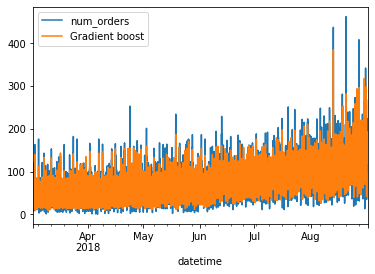

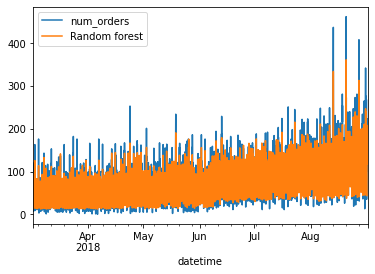

In [57]:
compare = pd.DataFrame()
compare['num_orders'] = y
compare['Gradient boost'] = gradient_boosting_model.predict(x)
compare['Random forest'] = random_forest_model_gs.predict(x)
compare[['num_orders','Gradient boost']].plot()
compare[['num_orders','Random forest']].plot()

Случайный лес, в целом лучше предсказывает, в том числе и значения августовских пиков.

## Вывод

Подготовили данные, провели ресеплинг с суммированием по 1 часу. Провели анализ данных, имеем нестационарный ряд, с сезонностью от времени суток и трендом на увеличение количества заказов в лентий период. Данные распределеены почти нормально, с небольшим смещением вправо.

Для обучения моделей добавили признаки. час, день недели. скользящее среднее и сдвиг, в количестве 25 значений.
Обучили несколько моделей: линейная регрессия, ElasticNet, дерево решений, случайны лес и градиентный бустинг.

Лучший показатель метрики показал случайны лес, но при этом он затрачивает максимальное время на обучение с подбором гиперпараметров. Второй по качеству показатель показала модель градиентного бустинга, но с большим отставанием от случайного леса. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48